In [1]:
#LSTM from scratch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class WeightInitializer:
    def __init__(self, method='random'):
        self.method = method

    def initialize(self, shape):
        if self.method == 'random':
            return np.random.randn(*shape)
        elif self.method == 'xavier':
            return np.random.randn(*shape) / np.sqrt(shape[0])
        elif self.method == 'he':
            return np.random.randn(*shape) * np.sqrt(2 / shape[0])
        elif self.method == 'uniform':
            return np.random.uniform(-1, 1, shape)
        else:
            raise ValueError(f'Unknown initialization method: {self.method}')

In [2]:
class PlotManager:
    def __init__(self):
        # Create a single axis for plotting
        self.fig, self.ax = plt.subplots(figsize=(6, 4))  # One plot only

    def plot_losses(self, train_losses, val_losses):
        self.ax.plot(train_losses, label='Training Loss')
        self.ax.plot(val_losses, label='Validation Loss')
        self.ax.set_title('Training and Validation Losses')
        self.ax.set_xlabel('Epoch')
        self.ax.set_ylabel('Loss')
        self.ax.legend()

    def show_plots(self):
        plt.tight_layout()
        plt.show()  # Display the plot


In [3]:
class EarlyStopping:
    """
    Early stopping to stop the training when the loss does not improve after

    Args:
    -----
        patience (int): Number of epochs to wait before stopping the training.
        verbose (bool): If True, prints a message for each epoch where the loss
                        does not improve.
        delta (float): Minimum change in the monitored quantity to qualify as an improvement.
    """
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        """
        Determines if the model should stop training.
        
        Args:
            val_loss (float): The loss of the model on the validation set.
        """
        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0   
    

In [4]:
class LSTM:
    """
    Long Short-Term Memory (LSTM) network.
    
    Parameters:
    - input_size: int, dimensionality of input space
    - hidden_size: int, number of LSTM units
    - output_size: int, dimensionality of output space
    - init_method: str, weight initialization method (default: 'xavier')
    """
    def __init__(self, input_size, hidden_size, output_size, init_method='xavier'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weight_initializer = WeightInitializer(method=init_method)

        # Initialize weights
        self.wf = self.weight_initializer.initialize((hidden_size, hidden_size + input_size))
        self.wi = self.weight_initializer.initialize((hidden_size, hidden_size + input_size))
        self.wo = self.weight_initializer.initialize((hidden_size, hidden_size + input_size))
        self.wc = self.weight_initializer.initialize((hidden_size, hidden_size + input_size))

        # Initialize biases
        self.bf = np.zeros((hidden_size, 1))
        self.bi = np.zeros((hidden_size, 1))
        self.bo = np.zeros((hidden_size, 1))
        self.bc = np.zeros((hidden_size, 1))

        # Initialize output layer weights and biases
        self.why = self.weight_initializer.initialize((output_size, hidden_size))
        self.by = np.zeros((output_size, 1))

    @staticmethod
    def sigmoid(z):
        """
        Sigmoid activation function.
        
        Parameters:
        - z: np.ndarray, input to the activation function
        
        Returns:
        - np.ndarray, output of the activation function
        """
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def dsigmoid(y):
        """
        Derivative of the sigmoid activation function.

        Parameters:
        - y: np.ndarray, output of the sigmoid activation function

        Returns:
        - np.ndarray, derivative of the sigmoid function
        """
        return y * (1 - y)

    @staticmethod
    def dtanh(y):
        """
        Derivative of the hyperbolic tangent activation function.

        Parameters:
        - y: np.ndarray, output of the hyperbolic tangent activation function

        Returns:
        - np.ndarray, derivative of the hyperbolic tangent function
        """
        return 1 - y * y

    def forward(self, x):
        """
        Forward pass through the LSTM network.

        Parameters:
        - x: np.ndarray, input to the network

        Returns:
        - np.ndarray, output of the network
        - list, caches containing intermediate values for backpropagation
        """
        caches = []
        h_prev = np.zeros((self.hidden_size, 1))
        c_prev = np.zeros((self.hidden_size, 1))
        h = h_prev
        c = c_prev

        for t in range(x.shape[0]):
            x_t = x[t].reshape(-1, 1)
            combined = np.vstack((h_prev, x_t))
            
            f = self.sigmoid(np.dot(self.wf, combined) + self.bf)
            i = self.sigmoid(np.dot(self.wi, combined) + self.bi)
            o = self.sigmoid(np.dot(self.wo, combined) + self.bo)
            c_ = np.tanh(np.dot(self.wc, combined) + self.bc)
            
            c = f * c_prev + i * c_
            h = o * np.tanh(c)

            cache = (h_prev, c_prev, f, i, o, c_, x_t, combined, c, h)
            caches.append(cache)

            h_prev, c_prev = h, c

        y = np.dot(self.why, h) + self.by
        return y, caches

    def backward(self, dy, caches, clip_value=1.0):
        """
        Backward pass through the LSTM network.

        Parameters:
        - dy: np.ndarray, gradient of the loss with respect to the output
        - caches: list, caches from the forward pass
        - clip_value: float, value to clip gradients to (default: 1.0)

        Returns:
        - tuple, gradients of the loss with respect to the parameters
        """
        dWf, dWi, dWo, dWc = [np.zeros_like(w) for w in (self.wf, self.wi, self.wo, self.wc)]
        dbf, dbi, dbo, dbc = [np.zeros_like(b) for b in (self.bf, self.bi, self.bo, self.bc)]
        dWhy = np.zeros_like(self.why)
        dby = np.zeros_like(self.by)

        # Ensure dy is reshaped to match output size
        dy = dy.reshape(self.output_size, -1)
        dh_next = np.zeros((self.hidden_size, 1))  # shape must match hidden_size
        dc_next = np.zeros_like(dh_next)

        for cache in reversed(caches):
            h_prev, c_prev, f, i, o, c_, x_t, combined, c, h = cache

            # Add gradient from next step to current output gradient
            dh = np.dot(self.why.T, dy) + dh_next
            dc = dc_next + (dh * o * self.dtanh(np.tanh(c)))

            df = dc * c_prev * self.dsigmoid(f)
            di = dc * c_ * self.dsigmoid(i)
            do = dh * self.dtanh(np.tanh(c))
            dc_ = dc * i * self.dtanh(c_)

            dcombined_f = np.dot(self.wf.T, df)
            dcombined_i = np.dot(self.wi.T, di)
            dcombined_o = np.dot(self.wo.T, do)
            dcombined_c = np.dot(self.wc.T, dc_)

            dcombined = dcombined_f + dcombined_i + dcombined_o + dcombined_c
            dh_next = dcombined[:self.hidden_size]
            dc_next = f * dc

            dWf += np.dot(df, combined.T)
            dWi += np.dot(di, combined.T)
            dWo += np.dot(do, combined.T)
            dWc += np.dot(dc_, combined.T)

            dbf += df.sum(axis=1, keepdims=True)
            dbi += di.sum(axis=1, keepdims=True)
            dbo += do.sum(axis=1, keepdims=True)
            dbc += dc_.sum(axis=1, keepdims=True)

        dWhy += np.dot(dy, h.T)
        dby += dy

        gradients = (dWf, dWi, dWo, dWc, dbf, dbi, dbo, dbc, dWhy, dby)

        # Gradient clipping
        for i in range(len(gradients)):
            np.clip(gradients[i], -clip_value, clip_value, out=gradients[i])

        return gradients

    def update_params(self, grads, learning_rate):
        """
        Update the parameters of the network using the gradients.

        Parameters:
        - grads: tuple, gradients of the loss with respect to the parameters
        - learning_rate: float, learning rate
        """
        dWf, dWi, dWo, dWc, dbf, dbi, dbo, dbc, dWhy, dby = grads

        self.wf -= learning_rate * dWf
        self.wi -= learning_rate * dWi
        self.wo -= learning_rate * dWo
        self.wc -= learning_rate * dWc

        self.bf -= learning_rate * dbf
        self.bi -= learning_rate * dbi
        self.bo -= learning_rate * dbo
        self.bc -= learning_rate * dbc

        self.why -= learning_rate * dWhy
        self.by -= learning_rate * dby

In [5]:
class LSTMTrainer:
    """
    Trainer for the LSTM network.

    Parameters:
    - model: LSTM, the LSTM network to train
    - learning_rate: float, learning rate for the optimizer
    - patience: int, number of epochs to wait before early stopping
    - verbose: bool, whether to print training information
    - delta: float, minimum change in validation loss to qualify as an improvement
    """
    def __init__(self, model, learning_rate=0.01, patience=7, verbose=True, delta=0):
        self.model = model
        self.learning_rate = learning_rate
        self.train_losses = []
        self.val_losses = []
        self.early_stopping = EarlyStopping(patience, verbose, delta)

    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=10, batch_size=1, clip_value=1.0):
        """
        Train the LSTM network.

        Parameters:
        - X_train: np.ndarray, training data
        - y_train: np.ndarray, training labels
        - X_val: np.ndarray, validation data
        - y_val: np.ndarray, validation labels
        - epochs: int, number of training epochs
        - batch_size: int, size of mini-batches
        - clip_value: float, value to clip gradients to
        """
        for epoch in range(epochs):
            epoch_losses = []
            for i in range(0, len(X_train), batch_size):
                batch_X = X_train[i:i + batch_size]
                batch_y = y_train[i:i + batch_size]
                losses = []
                
                for x, y_true in zip(batch_X, batch_y):
                    y_pred, caches = self.model.forward(x)
                    loss = self.compute_loss(y_pred, y_true.reshape(-1, 1))
                    losses.append(loss)
                    
                    # Backpropagation to get gradients
                    dy = y_pred - y_true.reshape(-1, 1)
                    grads = self.model.backward(dy, caches, clip_value=clip_value)
                    self.model.update_params(grads, self.learning_rate)

                batch_loss = np.mean(losses)
                epoch_losses.append(batch_loss)

            avg_epoch_loss = np.mean(epoch_losses)
            self.train_losses.append(avg_epoch_loss)

            if X_val is not None and y_val is not None:
                val_loss = self.validate(X_val, y_val)
                self.val_losses.append(val_loss)
                print(f'Epoch {epoch + 1}/{epochs} - Loss: {avg_epoch_loss:.5f}, Val Loss: {val_loss:.5f}')
                
                # Check early stopping condition
                self.early_stopping(val_loss)
                if self.early_stopping.early_stop:
                    print("Early stopping")
                    break
            else:
                print(f'Epoch {epoch + 1}/{epochs} - Loss: {avg_epoch_loss:.5f}')


    def compute_loss(self, y_pred, y_true):
        """
        Compute mean squared error loss.
        """
        return np.mean((y_pred - y_true) ** 2)

    def validate(self, X_val, y_val):
        """
        Validate the model on a separate set of data.
        """
        val_losses = []
        for x, y_true in zip(X_val, y_val):
            y_pred, _ = self.model.forward(x)
            loss = self.compute_loss(y_pred, y_true.reshape(-1, 1))
            val_losses.append(loss)
        return np.mean(val_losses)

In [6]:
class TimeSeriesDataset:
    """
    Dataset class for time series data.

    Parameters:
    - ticker: str, stock ticker symbol
    - start_date: str, start date for data retrieval
    - end_date: str, end date for data retrieval
    - look_back: int, number of previous time steps to include in each sample
    - train_size: float, proportion of data to use for training
    """
    def __init__(self, start_date, end_date, look_back=1, train_size=0.67):
        self.start_date = start_date
        self.end_date = end_date
        self.look_back = look_back
        self.train_size = train_size

    def load_data(self):
        """
        Load stock data.
        
        Returns:
        - np.ndarray, training data
        - np.ndarray, testing data
        """
        df = pd.read_csv('Google_Stock_Train (2010-2022).csv')
        df = df[(df['Date'] >= self.start_date) & (df['Date'] <= self.end_date)]
        df = df.sort_index()
        df = df.loc[self.start_date:self.end_date]
        df = df[['Close']].astype(float)  # Use closing price
        df = self.MinMaxScaler(df.values)  # Convert DataFrame to numpy array
        train_size = int(len(df) * self.train_size)
        train, test = df[0:train_size,:], df[train_size:len(df),:]
        return train, test
    
    def MinMaxScaler(self, data):
        """
        Min-max scaling of the data.
        
        Parameters:
        - data: np.ndarray, input data
        """
        numerator = data - np.min(data, 0)
        denominator = np.max(data, 0) - np.min(data, 0)
        return numerator / (denominator + 1e-7)

    def create_dataset(self, dataset):
        """
        Create the dataset for time series prediction.

        Parameters:
        - dataset: np.ndarray, input data

        Returns:
        - np.ndarray, input data
        - np.ndarray, output data
        """
        dataX, dataY = [], []
        for i in range(len(dataset)-self.look_back):
            a = dataset[i:(i + self.look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + self.look_back, 0])
        return np.array(dataX), np.array(dataY)

    def get_train_test(self):
        """
        Get the training and testing data.

        Returns:
        - np.ndarray, training input
        - np.ndarray, training output
        - np.ndarray, testing input
        - np.ndarray, testing output
        """
        train, test = self.load_data()
        trainX, trainY = self.create_dataset(train)
        testX, testY = self.create_dataset(test)
        return trainX, trainY, testX, testY

In [7]:
# Instantiate the dataset
dataset = TimeSeriesDataset( '2010-1-1', '2020-12-31', look_back=1)
trainX, trainY, testX, testY = dataset.get_train_test()

In [8]:
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [9]:
look_back = 1  # Number of previous time steps to include in each sample
hidden_size = 256  # Number of LSTM units
output_size = 1  # Dimensionality of the output space

lstm = LSTM(input_size=1, hidden_size=hidden_size, output_size=output_size)

In [10]:
trainer = LSTMTrainer(lstm, learning_rate=1e-3, patience=50, verbose=True, delta=0.001)
trainer.train(trainX, trainY, testX, testY, epochs=1000, batch_size=32)

Epoch 1/1000 - Loss: 0.48420, Val Loss: 1.25261
Epoch 2/1000 - Loss: 0.42614, Val Loss: 1.12504
Epoch 3/1000 - Loss: 0.37687, Val Loss: 1.01331
Epoch 4/1000 - Loss: 0.33507, Val Loss: 0.91529
Epoch 5/1000 - Loss: 0.29960, Val Loss: 0.82915
Epoch 6/1000 - Loss: 0.26948, Val Loss: 0.75329
Epoch 7/1000 - Loss: 0.24388, Val Loss: 0.68636
Epoch 8/1000 - Loss: 0.22210, Val Loss: 0.62719
Epoch 9/1000 - Loss: 0.20356, Val Loss: 0.57478
Epoch 10/1000 - Loss: 0.18775, Val Loss: 0.52825
Epoch 11/1000 - Loss: 0.17426, Val Loss: 0.48687
Epoch 12/1000 - Loss: 0.16273, Val Loss: 0.44997
Epoch 13/1000 - Loss: 0.15285, Val Loss: 0.41702
Epoch 14/1000 - Loss: 0.14438, Val Loss: 0.38752
Epoch 15/1000 - Loss: 0.13710, Val Loss: 0.36106
Epoch 16/1000 - Loss: 0.13082, Val Loss: 0.33728
Epoch 17/1000 - Loss: 0.12540, Val Loss: 0.31586
Epoch 18/1000 - Loss: 0.12070, Val Loss: 0.29653
Epoch 19/1000 - Loss: 0.11661, Val Loss: 0.27905
Epoch 20/1000 - Loss: 0.11304, Val Loss: 0.26320
Epoch 21/1000 - Loss: 0.10991

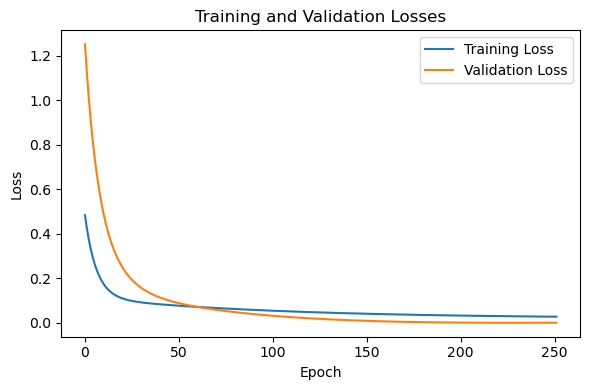

In [12]:
plot_manager = PlotManager()

# Inside your training loop
plot_manager.plot_losses(trainer.train_losses, trainer.val_losses)

# After your training loop
plot_manager.show_plots()